# Versión oficial para cargar la data de entrenamiento
A su gusto

# Librerías

In [1]:
import os
import json
import re
import math
import random
from typing import Any, Dict, List, Optional
import csv
import time
import datetime as dt

import torch
from torch.utils.data import DataLoader, Dataset as TorchDataset
from torch.optim import AdamW
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.utils.checkpoint
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

# Importar archivos .py personalizados
import evaluation_metric as custom_metrics #el archivo .py con las métricas personalizadas, proveida por el curso
import shared_functions as custom_sharfun  #el archivo .py con funciones compartidas

#import warnings
from importlib.metadata import version

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    get_scheduler
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import logging as hf_logging
hf_logging.set_verbosity_warning()

In [2]:
start_time = time.time()
print("Inicio de ejecución:", dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Inicio de ejecución: 2025-11-23 09:41:49


In [3]:
# Ignorar las warnings
#warnings.filterwarnings("ignore")  → dejar esto al final para la entrega, dado que se debe revisar que se debe mejorar en el código

# Versiones utilizadas
librerias = [
    "numpy",
    "matplotlib",
    "torch",
    "tqdm",
    "datasets",
    "transformers",
    "peft",
    "importlib-metadata"
]
for library in librerias:
    print(library, ": ", version(library))

!python --version

numpy :  2.1.2
matplotlib :  3.10.6
torch :  2.10.0.dev20251012+cu130
tqdm :  4.67.1
datasets :  4.0.0
transformers :  4.57.1
peft :  0.17.1
importlib-metadata :  8.7.0
Python 3.13.5


# Variables globales y funciones auxiliares

### Valores por defecto

In [4]:
# Directorios
TOTAL_FILES_TO_TRAIN = 9 # aquí ponga el número total de archivos json que desea usar para entrenar
DATA_PATH = "data/train" # aqui ponga los archivos json de entrenamiento, descargados de la competencia
OUTPUT_DIR = "output/results/v01"
EXPECTED_JSON_FILE = "data/template/expected_output.json"
EXPECTED_JSON = None
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Modelo
MODEL_NAME = "Qwen/Qwen3-0.6B-Base"

# Configuración del dispositivo + semillas
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
GLB_SEED = 42
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)

Using device: cuda


### Valores globales de prueba

In [5]:
# Data / tokenization
TEST_SIZE = 0.2
MAX_LENGTH = 1252 # Obtenido al percentil 99%

# Dataloader
BATCH_SIZE = 2
#NUM_WORKERS = 2

# Entrenamiento
GRAD_ACCUM_STEPS = 6
EPOCHS = 5
WARMUP_RATIO = 0.03 # 5% de los steps totales, sugerencia otra 0.03
#WARMUP_STEPS = 10 # con 10 va bien # revisar este 100, mejor usar WARMUP_RATIO

# AdamW
LEARNING_RATE = 1e-4 # con 2e-4 es agresivo pero funciona bien, riesgo de overfitting
WEIGHT_DECAY = 0.01
BETAS = (0.9, 0.999)
EPS = 1e-8
SCHEDULER_TYPE = "linear" # linear, cosine, cosine_with_restarts, polynomial, constant, constant_with_warmup  #cosine no va bien
CLIP_NORM = 1.0

# LoRA
LORA_R = 32
LORA_ALPHA = 64
LORA_DROPOUT = 0.05
TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj"]

# Evaluación
NUM_VAL_EXAMPLES = 45
GEN_MAX_NEW_TOKENS = 377 # Ajustado a partir de analisis de percentiles
BEAM_CANDIDATES = 5

# Carga de archivos y datos

Cargar archivo ejemplo JSON esperado para predicción, aunque no se usa todavía, es para mejorar un poco la prediccion...

In [6]:
with open(EXPECTED_JSON_FILE, "r", encoding="utf-8") as f:
    EXPECTED_JSON = json.load(f)

**Cargar dataset**   
Los N archivos con los que desea entrenar el modelo.

In [7]:
# Cargar datos de entrenamiento, lea los archivos de la carpeta train
raw_data = []
files = sorted([f for f in os.listdir(DATA_PATH) if f.endswith(".json")])[:TOTAL_FILES_TO_TRAIN]

for file_name in files:
    file_path = os.path.join(DATA_PATH, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        # Si cada archivo tiene una lista de diccionarios, la agregamos
        if isinstance(data, list):
            raw_data.extend(data)
        elif isinstance(data, dict):
            raw_data.append(data)
        else:
            raise ValueError(f"Formato no esperado en {file_name}")

print(f"Total training files loaded: {len(raw_data)}")

clean_data = []
dropped = 0
for item in raw_data:
    natural = item.get("natural_language")
    json_d = item.get("json_data")
    if natural is None or natural == "" or json_d is None:
        dropped += 1
        continue
    clean_data.append(item)

print(f"Registros válidos después de limpiar: {len(clean_data)} (eliminados: {dropped})")

Total training files loaded: 9000
Registros válidos después de limpiar: 8998 (eliminados: 2)


In [8]:
# convert to Hugging Face Dataset
hf_dataset = Dataset.from_list(clean_data)

# split train / validation
split = hf_dataset.train_test_split(test_size=TEST_SIZE, seed=GLB_SEED)
train_list = split['train']
val_list = split['test']

print(f"Train examples: {len(train_list)}, Val examples: {len(val_list)}")
print(hf_dataset)
print(f"Número de registros cargados: {len(hf_dataset)}")
print(type(hf_dataset))

Train examples: 7198, Val examples: 1800
Dataset({
    features: ['natural_language', 'json_data'],
    num_rows: 8998
})
Número de registros cargados: 8998
<class 'datasets.arrow_dataset.Dataset'>


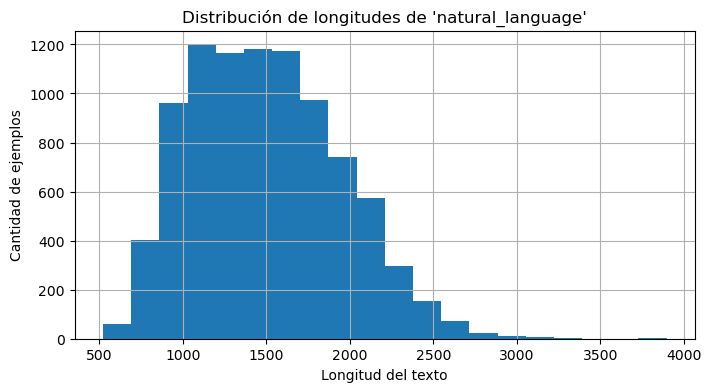

In [9]:
# Obtener longitudes de texto para ajustar MAX_LENGTH - histograma
longitudes = [
    len(item["natural_language"])
    for item in clean_data
    if item.get("natural_language") is not None
]  #Algunos registros tenían este campo en None
plt.figure(figsize=(8, 4))
plt.hist(longitudes, bins=20)  # puedes ajustar el número de bins
plt.title("Distribución de longitudes de 'natural_language'")
plt.xlabel("Longitud del texto")
plt.ylabel("Cantidad de ejemplos")
plt.grid(True)
plt.show()

In [10]:
print("Cargando tokenizer y modelo (esto puede tardar)...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True) # dejar trust_remote_code=True para Qwen
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    dtype=torch.bfloat16
)

# preparar para k-bit training
model = prepare_model_for_kbit_training(model)

# Desactivar cache y habilitar checkpointing seguro
model.config.use_cache = False
try:
    model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
except TypeError:
    # fallback if the signature is different
    model.gradient_checkpointing_enable()
torch.utils.checkpoint.use_reentrant = False

# Configurar LoRA
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Cargando tokenizer y modelo (esto puede tardar)...
trainable params: 9,175,040 || all params: 605,224,960 || trainable%: 1.5160


In [11]:
lengths_tokens = []
for ex in clean_data:
    txt = custom_sharfun.build_training_example(ex)
    enc = tokenizer(txt, truncation=False, padding=False)
    lengths_tokens.append(len(enc["input_ids"]))

np.percentile(lengths_tokens, [90, 95, 99])

array([1076.  , 1148.  , 1261.03])

In [12]:
import json
import numpy as np

def medir_longitudes_tokens(dataset, tokenizer, max_ejemplos=None):
    prompt_lens = []
    json_lens = []
    full_lens = []
    
    for i, ex in enumerate(dataset):
        if max_ejemplos is not None and i >= max_ejemplos:
            break
        
        # Texto natural y JSON objetivo de tu dataset
        natural = ex["natural_language"]
        target_json_str = json.dumps(ex["json_data"], ensure_ascii=False)
        
        # Construir el mismo prompt que usas en train/eval
        prompt = custom_sharfun.build_prompt(natural)
        full_text = prompt + target_json_str
        
        # Tokenizar SIN truncar ni hacer padding fijo
        enc_prompt = tokenizer(
            prompt,
            truncation=False,
            padding=False,
            add_special_tokens=True,
        )
        enc_full = tokenizer(
            full_text,
            truncation=False,
            padding=False,
            add_special_tokens=True,
        )
        
        lp = len(enc_prompt["input_ids"])
        lf = len(enc_full["input_ids"])
        lj = lf - lp  # aproximación a longitud del JSON
        
        prompt_lens.append(lp)
        full_lens.append(lf)
        json_lens.append(lj)
    
    stats = {
        "prompt_mean": float(np.mean(prompt_lens)),
        "prompt_p95": float(np.percentile(prompt_lens, 95)),
        "prompt_p99": float(np.percentile(prompt_lens, 99)),
        
        "json_mean": float(np.mean(json_lens)),
        "json_p95": float(np.percentile(json_lens, 95)),
        "json_p99": float(np.percentile(json_lens, 99)),
        
        "full_mean": float(np.mean(full_lens)),
        "full_p95": float(np.percentile(full_lens, 95)),
        "full_p99": float(np.percentile(full_lens, 99)),
        "full_max": int(np.max(full_lens)),
    }
    return stats


In [13]:
stats_val = medir_longitudes_tokens(val_list, tokenizer, max_ejemplos=None)
stats_val


{'prompt_mean': 665.2472222222223,
 'prompt_p95': 877.0,
 'prompt_p99': 954.03,
 'json_mean': 207.12222222222223,
 'json_p95': 313.0,
 'json_p99': 337.0,
 'full_mean': 872.3694444444444,
 'full_p95': 1153.1,
 'full_p99': 1252.01,
 'full_max': 1466}

## Construcción del prompt para que genere el JSON

In [14]:
# Tokenizar datos de entrenamiento y validación
#train_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer) for x in train_list]
#val_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer) for x in val_list]

train_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer,padding = False) for x in train_list]
val_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer, padding= False) for x in val_list]

# Simple Dataset + collate_fn (dinámico)
class SimpleTorchDataset(TorchDataset):
    def __init__(self, tokens_list):
        self.data = tokens_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {k: v for k, v in self.data[idx].items()}
    
train_dataset = SimpleTorchDataset(train_tokens)
val_dataset = SimpleTorchDataset(val_tokens)

def collate_fn(batch):
    input_ids = [b['input_ids'] for b in batch]
    attention_mask = [b['attention_mask'] for b in batch]
    labels = [b['labels'] for b in batch]

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

## Variación de parámetros para optimizador

 Optimizer (intenta Adam8bit de bitsandbytes, si no fallback a AdamW de torch).

 Notas:
 Adam8bit + get_scheduler cosine: no funciono bien, F1 siempre da cero, mejor AdamW

In [15]:
# Optimizer + Scheduler
total_steps_per_epoch  = math.ceil(len(train_loader) / GRAD_ACCUM_STEPS)
total_training_steps = EPOCHS * total_steps_per_epoch
num_warmup_steps = int(total_training_steps * WARMUP_RATIO) # warmup calculado desde warmup_ratio

print(f"Total training steps: {total_training_steps}, Warmup steps: {num_warmup_steps}")

# Optimizador
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=BETAS, eps=EPS)

# SCHEDULER CON WARMUP
scheduler = get_scheduler(name=SCHEDULER_TYPE, 
                          optimizer=optimizer, 
                          num_warmup_steps=num_warmup_steps, 
                          num_training_steps=total_training_steps)

Total training steps: 3000, Warmup steps: 90


In [16]:
#raise Exception("STOP - revisar código antes de continuar")

In [17]:
# Entrenamiento manual con AMP (torch.amp) y tqdm
scaler = torch.amp.GradScaler(device='cuda') if DEVICE.startswith('cuda') else torch.amp.GradScaler()
model.to(DEVICE)
model.train()

global_step = 0
optimizer.zero_grad()
for epoch in range(EPOCHS):
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    optimizer.zero_grad()
    for step, batch in pbar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with torch.amp.autocast(device_type='cuda' if DEVICE.startswith('cuda') else 'cpu'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / GRAD_ACCUM_STEPS

        scaler.scale(loss).backward()
        running_loss += loss.item() * GRAD_ACCUM_STEPS

        # UPDATE BLOCK: only when accumulation completes
        if (step + 1) % GRAD_ACCUM_STEPS == 0 or (step + 1) == len(train_loader):
            scaler.unscale_(optimizer)  # 1) Unscale gradients (necessary for clipping)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM) # 2) Clip gradients
            scaler.step(optimizer) # 3) Optimizer step (scaled)
            scheduler.step() # 4) Scheduler step → usa warmup aquí
            optimizer.zero_grad() # 5) Clear gradients
            scaler.update()  # 6) Scaler update
            global_step += 1

            avg_loss = running_loss / (step + 1)
            pbar.set_postfix({'loss': f"{avg_loss:.4f}", 'lr': scheduler.get_last_lr()[0]})
            #pbar.set_postfix({ "loss": f"{running_loss / (step+1):.4f}", "lr": scheduler.get_last_lr()[0]})

    print(f"Epoch {epoch+1} finished — avg loss: {running_loss / len(train_loader):.4f}")

Epoch 1/5:   0%|          | 0/3599 [00:00<?, ?it/s]

Epoch 1 finished — avg loss: 1.1877


Epoch 2/5:   0%|          | 0/3599 [00:00<?, ?it/s]

Epoch 2 finished — avg loss: 0.9675


Epoch 3/5:   0%|          | 0/3599 [00:00<?, ?it/s]

Epoch 3 finished — avg loss: 0.9233


Epoch 4/5:   0%|          | 0/3599 [00:00<?, ?it/s]

Epoch 4 finished — avg loss: 0.8979


Epoch 5/5:   0%|          | 0/3599 [00:00<?, ?it/s]

Epoch 5 finished — avg loss: 0.8818


In [18]:
# Entrenando modelo se demora: 11 minutos x epoca

In [19]:
# Guardar modelo para validar en datos test. 👈 aqui ver como se saca el "weights.pt"
OUTPUT_DIR_MODEL = os.path.join(OUTPUT_DIR, "modfinal")
os.makedirs(OUTPUT_DIR_MODEL, exist_ok=True)

model.save_pretrained(OUTPUT_DIR_MODEL)
tokenizer.save_pretrained(OUTPUT_DIR_MODEL)

print('Modelo para restaurar guardado en', OUTPUT_DIR_MODEL)

Modelo para restaurar guardado en output/results/v01\modfinal


In [21]:
CKPT_PATH = os.path.join(OUTPUT_DIR_MODEL, "weights.pt")
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "tokenizer": tokenizer.__dict__,  
    },
    CKPT_PATH
)
print("Checkpoint .pt guardado en:", CKPT_PATH)

Checkpoint .pt guardado en: output/results/v01\modfinal\weights.pt


## Validación del modelo entrenado en los datos test

Aqui tome 5 ejemplos solo como para validar

In [20]:
#NUM_VAL_EXAMPLES = 5 # si se desea hacer subset, de lo contrario dejar todo
# usar NUM_VAL_EXAMPLES: `for idx, ex in enumerate(tqdm(val_list.select(range(min(NUM_VAL_EXAMPLES, len(val_list)))), desc="Eval")):`
print("Tamaño conjunto de validación:", len(val_list))
NUM_VAL_EXAMPLES = len(val_list)

results = []
for idx, ex in enumerate(
    tqdm(val_list.select(range(min(NUM_VAL_EXAMPLES, len(val_list)))), desc="Eval")
):
    text = ex["natural_language"]
    raw = custom_sharfun.generate_json_raw(text=text, max_new_tokens=GEN_MAX_NEW_TOKENS, max_length=MAX_LENGTH, tokenizer=tokenizer, model=model, device=DEVICE) # aplica evaluacion del modelo
    pred_obj = custom_sharfun.extract_json_from_text(raw)
    true_json = ex["json_data"]

    if pred_obj is None:
        f1 = 0.0
    else:
        try:
            f1 = custom_metrics.evaluate_json(true_json, json.dumps(pred_obj, ensure_ascii=False))
        except Exception:
            f1 = float(1.0 if pred_obj == true_json else 0.0)

    print(f"Ejemplo {idx}: F1 = {f1:.4f}")
    results.append({"idx": idx, "f1": f1, "raw": raw, "pred": pred_obj, "true": true_json})

Tamaño conjunto de validación: 1800


Eval:   0%|          | 0/1800 [00:00<?, ?it/s]

Ejemplo 0: F1 = 0.6386
Ejemplo 1: F1 = 0.7305
Ejemplo 2: F1 = 0.7677
Ejemplo 3: F1 = 0.8383
Ejemplo 4: F1 = 0.6154
Ejemplo 5: F1 = 0.8352
Ejemplo 6: F1 = 0.7097
Ejemplo 7: F1 = 0.6541
Ejemplo 8: F1 = 0.7826
Ejemplo 9: F1 = 0.8702
Ejemplo 10: F1 = 1.0000
Ejemplo 11: F1 = 0.9086
Ejemplo 12: F1 = 0.4771
Ejemplo 13: F1 = 0.5590
Ejemplo 14: F1 = 0.7461
Ejemplo 15: F1 = 0.7831
Ejemplo 16: F1 = 0.7926
Ejemplo 17: F1 = 0.8916
Ejemplo 18: F1 = 0.8800
Ejemplo 19: F1 = 0.5462
Ejemplo 20: F1 = 0.7837
Ejemplo 21: F1 = 0.8258
Ejemplo 22: F1 = 0.8269
Ejemplo 23: F1 = 0.8816
Ejemplo 24: F1 = 0.9130
Ejemplo 25: F1 = 0.7926
Ejemplo 26: F1 = 0.7915
Ejemplo 27: F1 = 0.8373
Ejemplo 28: F1 = 0.6957
Ejemplo 29: F1 = 0.7646


KeyboardInterrupt: 

In [ ]:
# Validacion de 20% (datos test): 

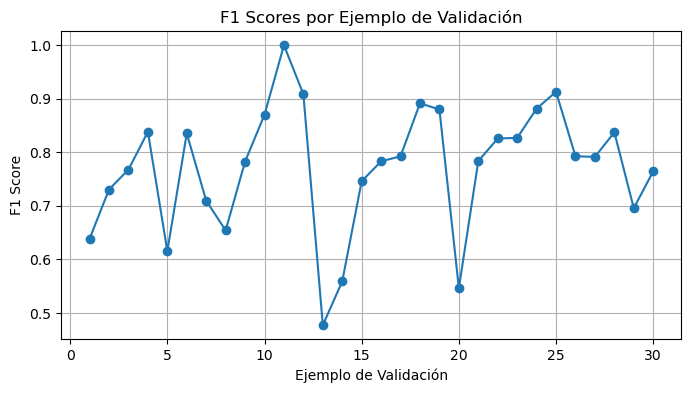

In [22]:
 # Resumen de resultados en test: ver histrograma de F1 scores
f1_scores = [r['f1'] for r in results]
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.title("F1 Scores por Ejemplo de Validación")
plt.xlabel("Ejemplo de Validación")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [ ]:
results[1] # observar que hay

In [23]:
# Guardar CSV - resultados de validación
OUTPUT_DIR_VAL = os.path.join(OUTPUT_DIR, "result_validation")
os.makedirs(OUTPUT_DIR_VAL, exist_ok=True)
csv_path = os.path.join(OUTPUT_DIR_VAL, 'validation_results.csv')
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['idx','f1','raw','pred','true'])
    writer.writeheader()
    for r in results:
        writer.writerow({
            'idx': r['idx'],
            'f1': r['f1'],
            'raw': r['raw'],
            'pred': json.dumps(r['pred'], ensure_ascii=False),
            'true': json.dumps(r['true'], ensure_ascii=False)
        })
print('CSV guardado en', csv_path)

CSV guardado en output/results/v01\result_validation\validation_results.csv


In [ ]:
# Histograma F1
f1_scores = [r['f1'] for r in results]
plt.figure()
plt.hist(f1_scores, bins=10)
plt.title('Distribución de F1')
plt.xlabel('F1')
plt.ylabel('Frecuencia')
plt.savefig(os.path.join(OUTPUT_DIR, 'f1_distribution.png'))
plt.show()
plt.close()
print('Histograma guardado en', os.path.join(OUTPUT_DIR, 'f1_distribution.png'))

In [24]:
# Mostrar peores 3 ejemplos
sorted_by_f1 = sorted(results, key=lambda x: x['f1'])
print('\nPeores 3 ejemplos:')
for r in sorted_by_f1[:3]:
    print(f"Ejemplo #{r['idx']} - F1 Score: {r['f1']}")
    print('Texto:', r['raw'])
    print("*"*90)
    print('Pred_normalizado:', r['pred'])
    print('True:', r['true'])
    print('-'*150)


Peores 3 ejemplos:
Ejemplo #12 - F1 Score: 0.47706422018348627
Texto: Eres un extractor de órdenes de compra. Genera SOLO un JSON válido EXACTAMENTE con los campos requeridos.
Reglas:
- Usa null cuando un campo no exista.
- "buyer" debe existir; si name/email/contact/addresses faltan, déjalos en null.
- Si addresses está vacío o no existe -> "addresses": null.
- Si purchases está vacío o no existe -> "purchases": null.
- shipping es opcional; si falta -> "shipping": null.
- Asegura que los tipos de datos principales sean correctos (quantity: entero; country uno de US/CA/GB/ES/CO/DE/FR).

- Use null cuando no tengas información, y que NO inventes correos, teléfonos o códigos de descuento si no aparecen.
- Respeta exactamente los nombres de los campos del esquema.
- Estructura el problema paso a paso, razona por etapas.
Texto:
Hey! 😊 Espero que estés bien. Te escribo porque necesito hacer un pedido, una vez más. La vez pasada que hice algo similar, me quedé muy contenta, así que decidí 

In [25]:
end_time = time.time()
elapsed_sec = end_time - start_time
elapsed_min = elapsed_sec / 60

print(f"Fin de ejecución: {dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Tiempo total: {elapsed_sec:.1f} segundos (~{elapsed_min:.2f} minutos)")

Fin de ejecución: 2025-11-23 13:38:25
Tiempo total: 14196.4 segundos (~236.61 minutos)
